## Introduction
The purpose of this analysis is to design a model that can use chest x-ray images to identify pneumonia. According to the American Thoracic Society, pneumonia is the [leading cause of death](https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf) among children under age 5, accounting for roughly 16% of all deaths within that age range in 2015. The application of machine learning techniques such as neural networks can help identify the presence of pneumonia using exclusively chest x-rays. 


### Data Sources
The data used in this analysis was original provided by Mendeley Data and is publicly available [here](https://data.mendeley.com/datasets/rscbjbr9sj/3) (1). The dataset was subsequently adapted to a Kaggle dataset, which can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In total, 5856 X-ray images in jpeg format are provided. Each is already labeled to indicate whether or not pneumonia is present.

### The Process

This analysis will follow the general structure listed here:
1. Import packages and data
2. Function definitions
3. Modeling
4. Evaluation
5. Conclusion

## Part 1. Import packages and data

##### Package Imports
The below packages are necessary for various functionality throughout the analysis

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys, os

# Use Scikit-learn for train-test splits and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Import various Keras/Tensorflow packages for neural networks
import keras
from keras import regularizers
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *

# Global static variable declarations
RANDOM_STATE = 2020 # Ensure repeatable results
VAL_SPLIT = 0.25 # Use 25% of data for validation and test splits

# Set resolution of each photo. Each image is downsampled to this size (in pixels)
TARGET_SIZE = 128

# Path "images" folder
IMG_PATH = '../images/'

##### Operating platform selection
Since this project has been run using local CPUs in addition to the GPUs offered by Google Colab and Kaggle Notebooks, the below cell quickly enables to user to select the platform of choice.

In [2]:
# Set 'platform' to any of the following: "kaggle", "colab", "local" depending on use case
platform = 'local'

def set_data_path(platform):
    
    # Set file paths if running on Kaggle notebook
    if platform == 'kaggle':
        path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
        path_val   = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/'
        path_test  = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
    
    # Set file paths if running on Google Colab
    elif platform == 'colab':
        path_train = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
        path_val   = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/val'
        path_test  = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/test'
        
        # Notebook must be "mounted" to drive to access stored data files
        from google.colab import drive
        drive.mount('/content/drive')

    # Set file paths if running locally
    elif platform == 'local':
        path_train = '../data/raw/train'
        path_val = '../data/raw/val'
        path_test  = '../data/raw/test'

    else:
        sys.exit('ERROR: PLEASE ENTER "kaggle", "colab" or "local"')
    
    return path_train, path_val, path_test


# Run function to determine the data paths for the platform being used
path_train, path_val, path_test = set_data_path(platform)

#### Data Imports
It has been made clear through external research that substantial data within the provided Test dataset has been mislabeled. As a result, a model cannot effectively predict correctly when trained on correctly labeled data. To address the issue, data from both Train and Test folders are imported, combined, then randomly split within this notebook. This minimizes the impact of mislabeled data and in turn creates a model that is more generalizable.

##### Create function to import all images from provided directory

In [3]:
def import_data(path, file_ct, resolution=TARGET_SIZE):
    # Batch size is defined such that *all* images in selected folder are imported in one batch
        
        
    # Instantiate Keras generator, scaling all RGB inputs from the 
    # default [0, 255] range to the [0, 1] range since neural network inputs should be 
    # normalized
    generator = ImageDataGenerator(rescale=1/255)

    # Create flow object to bring images from folders to memory
    gen_train = generator.flow_from_directory(directory=path, 
                                              target_size=(resolution, resolution), 
                                              batch_size=file_ct, 
                                              seed=RANDOM_STATE)
    # Store all images in numpy array
    data_and_labels = next(gen_train)

    
    return data_and_labels[0], data_and_labels[1] # images, labels

##### Run the above-defined function
Create datasets and aggregate them into one final dataset.

In [4]:
# Number of images selected folder
file_ct_train = 1349 + 3883
file_ct_val = 8 + 8
file_ct_test = 234 + 390

# Run above-defined function for each of the datasets
images, labels = import_data(path_train, file_ct_train)
images_val, labels_val = import_data(path_val, file_ct_val)
images_test, labels_test = import_data(path_test, file_ct_test)

# Aggregate all datasets into one for inputs and one for outputs
images = np.concatenate([images, images_val, images_test], axis=0)
labels = np.concatenate([labels, labels_val, labels_test], axis=0)

# Remove unnecessary data since memory issues can occur while running this script
del images_val, labels_val
del images_test, labels_test

# Enhance data understanding. Verify all images are imported as would be expected
print('Image data shape:', images.shape)
print('Label data shape:', labels.shape)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Image data shape: (5856, 8, 8, 3)
Label data shape: (5856, 2)


##### Perform a train-test split on all data

As mentioned above, there is reason to believe that the splits provided by the dataset publishers may be flawed. As a result, the below cell creates a split into training, validation, and test datasets.

In [5]:
# Classic train-test split for TEST data
x_train, x_test, y_train, y_test = train_test_split(images, labels, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=VAL_SPLIT)

# Classic train-test split for VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=VAL_SPLIT)


# Remove unnecessary data since memory issues can occur while running this script
del images, labels

## Step 2. Function definitions

Now that data has been imported, split and analyzed, the notebook soon proceeds to the modeling stage. However, first, valuable functions are defined to enable easier, consistent analysis of subsequent model iterations.

##### Define function to plot the performance of selected model across epoch iterations.

In [6]:
def plot_metrics(history, metrics=['accuracy'], val=True):
    
    # Create one plot for each metric being analyzed
    for metric in metrics:
        
        # Normalize casing to reduce possible errors
        metric=str.lower(metric)
        
        # Define 'x' variable according to the number of epochs
        x = range(len(history[metric]))

        # Create figure and plot the metric
        plt.figure()
        plt.plot(x, history[metric], label='Train')

        # If a validation split was used, plot its performance
        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        
        # Basic figure improvements
        plt.xlabel('Epochs')
        plt.title(metric)
        plt.legend();

##### Define function to plot the confusion matrices for selected models.

In [7]:
def show_confusion_matrix(model, images, labels, save_path):
    # Reformat the "Labels" data to enable ease of use of Confusion Matrix
    truth = (labels[:, 1]==1).astype('int')
    
    # Predict Labels using the inputted model
    preds = np.argmax(model.predict(images), axis=-1)

    # Instantiate confusion matrix, NOT normalized
    matrix = confusion_matrix(truth, preds)#, normalize='true')
    ConfusionMatrixDisplay(matrix).plot()
    plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Correctness of Model Predictions (COUNT)');

    if save_path != False:
        plt.savefig(save_path+"_count.png")
    
    # Instantiate confusion matrix, NORMALIZED
    matrix_norm = confusion_matrix(truth, preds, normalize='true')
    ConfusionMatrixDisplay(matrix_norm).plot()
    plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Correctness of Model Predictions (%)')
    
    if save_path != False:
        plt.savefig(save_path+"_percent.png")
    
    return matrix, matrix_norm

##### Define top-level function to aggregate the previously-defined two functions, in addition to printing several performance metrics. 

In [25]:
def acc_pre_rec_f1(truth, pred):
    print('Accuracy:', round(accuracy_score(truth, pred), 4)*100, "%")
    print('Precision:', round(precision_score(truth, pred), 4)*100, "%")
    print('Recall:', round(recall_score(truth, pred), 4)*100, "%")
    print('F1 score:', round(f1_score(truth, pred), 4)*100, "%");



def show_model_performance(model, x_val, y_val, fit=False, save_path=False):
    
    if fit != False:
        plot_metrics(fit.history)
    
    show_confusion_matrix(model, x_val, y_val, save_path)
    display(model.summary())
    
    # Reformat the "Labels" data to enable ease of use of Confusion Matrix
    truth = (y_val[:, 1]==1).astype('int')
    
    # Predict Labels using the inputted model
    preds = np.argmax(model.predict(x_val), axis=-1)

    # Print performance metrics
    acc_pre_rec_f1(truth, preds);


##### Instantiate and define callbacks and commonly used variables

#### Callbacks
- The EarlyStopping callback to eliminate the need for tuning the number of epochs used in a model. This way, the model can run until it has reached its maximum performance without wasting computational power. 
- The ModelCheckpoint callback is used to select the top-performing model over the full range of epochs used for each model training. 



In [9]:
early_stopper = EarlyStopping(monitor='val_loss', patience=10)

#### Input shape
- Define the shape of the input data that will be used throughout each of the subsequent models based on the resolution of the downsampled input images.

In [10]:
input_shape = (TARGET_SIZE, TARGET_SIZE, 3)

## Step 3. Modeling

Using the Keras *Sequential* model, the below models investigate combinations of various layer combinations, node counts, and normalizations to find the best performance. Note that for the purpose of this analysis, there was insufficient computational power to perform extensive grid searches of hyperparameters, as would be needed to fully optimize each model. Instead, research-backed estimates of high-performing hyperparameter combinations are made. Future improvements would include exhaustive hyperparameter optimization, but that will be left for future analyses with more computational resources. 

##### The Baseline Model
The baseline performance shows the performance of a *random guess* methodology, which can be helpful when first developing a model. It allows the question to be answered, *does the model actually provide any value?*

In [11]:
def baseline_model(y):
    random_choice = lambda x: np.random.choice([0, 1])
    preds_map = map(random_choice, y[:, 1])
    preds = np.array(list(preds_map))
    return preds

preds = baseline_model(y_val)
truth = y_val[:, 1]

acc_baseline = round(accuracy_score(truth, preds)*100, 2)
prec_baseline = round(precision_score(truth, preds)*100, 2)
rec_baseline = round(recall_score(truth, preds)*100, 2)
f1_baseline = round(f1_score(truth, preds)*100, 2)

print('\nBASELINE performance on validation data:')
print('-------------------------------')
print('Accuracy:', acc_baseline, "%")
print('Precision:', prec_baseline, "%")
print('Recall:', rec_baseline, "%")
print('F1 score:', f1_baseline, "%");


BASELINE performance on validation data:
-------------------------------
Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


##### The First Simple Model
Define the FSM using only one Dense layer with two nodes. This model flattens the input data and subsequently applies the one additional layer within nearly hyperparameters set to the default.  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 386       
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


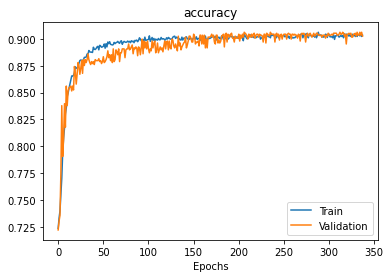

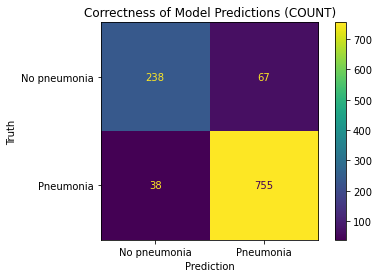

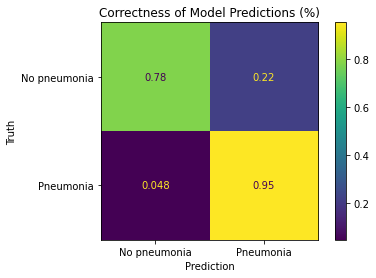

In [12]:
model_fsm = Sequential()
model_fsm.add(Flatten())
model_fsm.add(Dense(2, activation='softmax', 
             input_shape=input_shape))

model_fsm.compile(optimizer='SGD', 
                  metrics=['accuracy'], 
                  loss='categorical_crossentropy')



path_model = 'tmp/model_fsm.h5'

if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit_fsm = model_fsm.fit(x=x_train, 
                        y=y_train, 
                        epochs=500,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopper, check],
                        verbose=0)


model_fsm.load_weights(path_model)

show_model_performance(model_fsm, x_val, y_val, fit_fsm);

#### Add convolutional layer to previous model

Given an awareness that Convolutional Neural Networks (CNNs) are often top performing models for image classification, the below model adds a 2D convolutional layer to the previous model. The node count, kernel size and activation function were based on simple testing. Recall that there was insufficient computational power to perform grid searches of hyperparameters, as would be needed to fully optimize each model. 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 32)          4736      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 8,834
Trainable params: 8,834
Non-trainable params: 0
_________________________________________________________________


None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


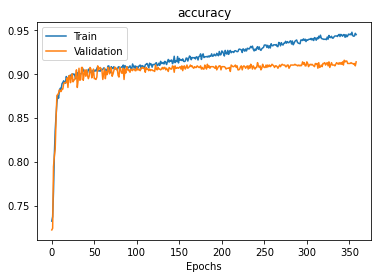

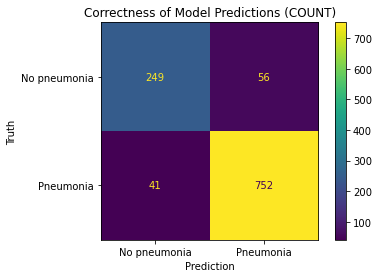

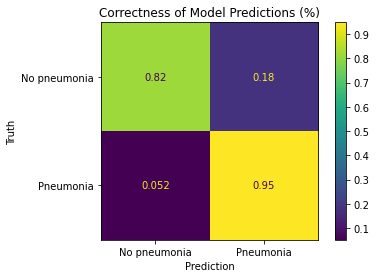

In [13]:
model = Sequential()
model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')


path_model = 'tmp/model_2.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model.load_weights(path_model)

show_model_performance(model, x_val, y_val, fit);

##### Increase node count substantially
Looking at the above accuracy plots over a range of epochs, the is clear that the model has a relatively low accuracy relative to a wide range of testing in the EDA phase of this project. Accordingly, additional nodes are added to the Convolutional layer of the below model to create a more tunable model. 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 64)          23296     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8194      
Total params: 31,490
Trainable params: 31,490
Non-trainable params: 0
_________________________________________________________________


None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


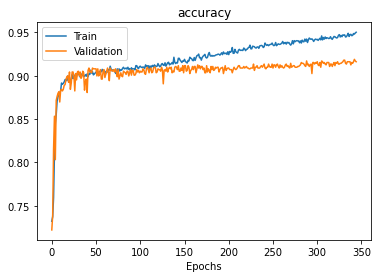

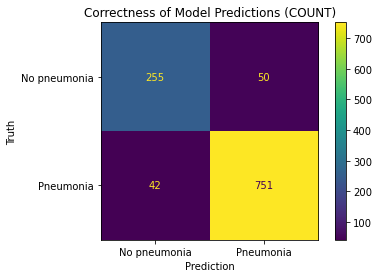

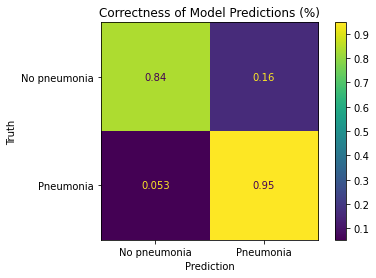

In [14]:
model = Sequential()
model.add(Conv2D(64, activation='relu',
                 kernel_size=11,  
                 input_shape=input_shape,
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

path_model = 'tmp/model_3.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model.load_weights(path_model)

show_model_performance(model, x_val, y_val, fit);

##### Instead, increase depth with pooling
As we can see, the accuracy actually decreased when adding extensive additional nodes. Instead of increasing the node count, we will return to a lower node count, and instead add an additional Convolutional layer, along with Pooling after each of the Convolutional layers.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 8, 8, 8)           1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 7,602
Trainable params: 7,602
Non-trainable params: 0
____________________________________________________

None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


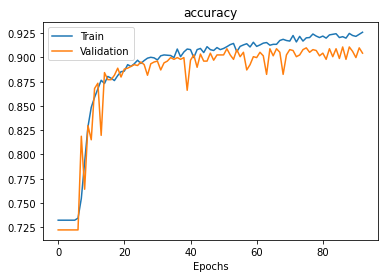

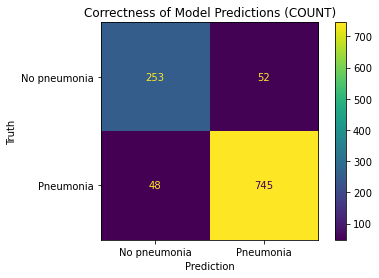

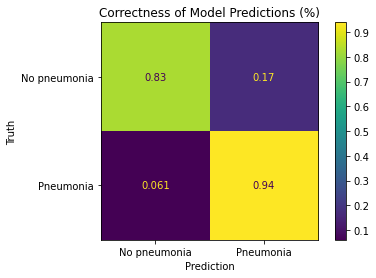

In [15]:
model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7,
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

path_model = 'tmp/model_4.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model.load_weights(path_model)

show_model_performance(model, x_val, y_val, fit);

##### Add one more Convolutional layer
After seeing that the above additon of a layer increased all performance metrics, in addition to reducing overfitting, the below model takes it one step further by adding another Convolutional layer to investigate the impact. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 8, 8, 8)           1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 16)          6288      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 32)          25120     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)               

None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


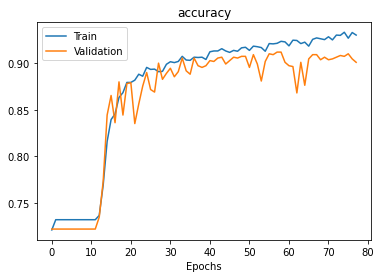

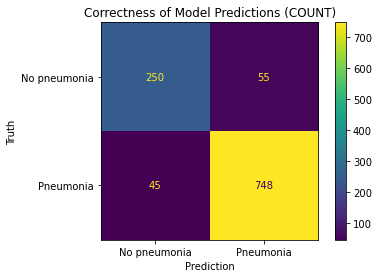

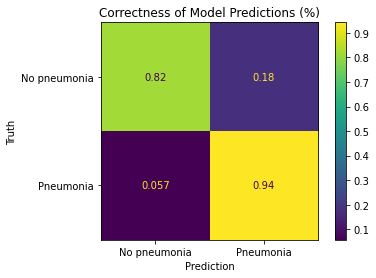

In [16]:
model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7, 
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

path_model = 'tmp/model_5.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model.load_weights(path_model)

show_model_performance(model, x_val, y_val, fit);

##### Add Regularization to top performing Convolutional

The additional layer above added accuracy and increased the F1 score relative to the previous model. However, it is still clear that there is overfitting. Regularization is a common solution for addressing overfitting. Accordingly, the below model adds L2 regularization to each Convolutional layer.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 8, 8, 8)           1184      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 16)          6288      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 32)          25120     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)               

None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


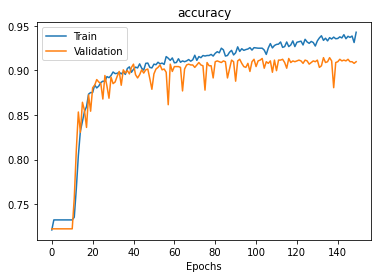

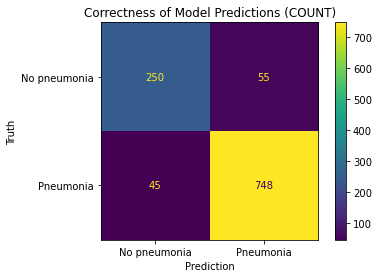

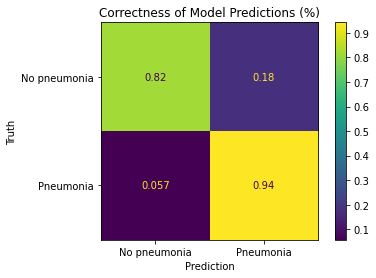

In [17]:
LAMBDA = 0.005

model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7,  
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

path_model = 'tmp/model_6.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model.load_weights(path_model)

show_model_performance(model, x_val, y_val, fit);

#### Add Dropout to top Convolutional
The performance of the above model didn't change substantially with the additional of regularization. The below model will add Dropout layers after each pooling layer to see if they can increase performance.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 8, 8, 8)           1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          6288      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 32)         

None

Accuracy: 49.09 %
Precision: 70.89 %
Recall: 50.06 %
F1 score: 58.68 %


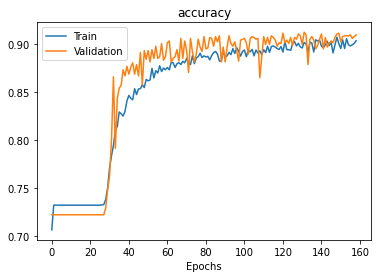

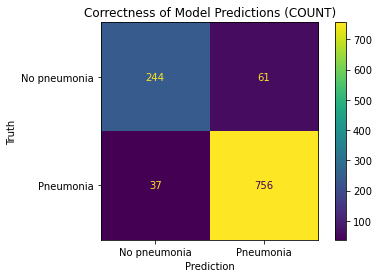

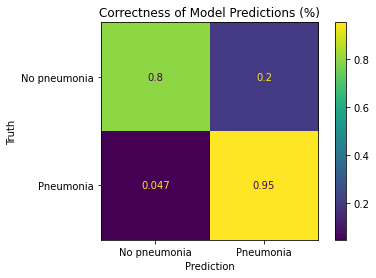

In [18]:
DROPOUT = 0.3
LAMBDA = 0.005

model = Sequential()
model.add(Conv2D(8, activation='relu',
                 kernel_size=7,  
                 input_shape=input_shape,
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(16, activation='relu',
                 kernel_size=7,
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(32, activation='relu',
                 kernel_size=7,  
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

path_model = 'tmp/model_7.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model.load_weights(path_model)

show_model_performance(model, x_val, y_val, fit);

##### The top performer
After looking at each of the printed performance metrics for the above model, it appears to perform better than all predecessors. It is accordingly selected as the top performing model and will be applied to the Test dataset below. 

In [19]:
# Copy the model and fit from the preceding model since it was
# determined to be the best model
model_top = model
fit_top = fit

## Step 4. Evaluation
Now that the top performing model has been selected, it will be retrained using both *train* and *validation* datasets before being tested on the withheld, previously untouched *test* dataset. Note that this same process is repeated for the FSM in order to compare performance improvements. 

##### Train FSM on full dataset (Training and Validation)

In [20]:
path_model = 'tmp/final_model_fsm.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit_fsm = model_fsm.fit(x=np.concatenate([x_train, x_val], axis=0), 
                y=np.concatenate([y_train, y_val], axis=0),
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model_fsm.load_weights(path_model)

##### Train Top Model on full dataset (Training and Validation)

In [21]:
path_model = 'tmp/final_model_top.h5'
if os.path.exists(path_model):
    os.remove(path_model)
check = ModelCheckpoint(path_model,save_best_only=True)

fit_top = model_top.fit(x=np.concatenate([x_train, x_val], axis=0), 
                y=np.concatenate([y_train, y_val], axis=0),
                epochs=500,
                callbacks=[early_stopper, check],
                validation_data=(x_val, y_val),
                verbose=0)

model_top.load_weights(path_model)

### Measure performance on Test data
Now that the FSM and top model are fully trained, they are evaluated below on the *test* data.

##### First Simple Model performance

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 386       
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


None

Accuracy: 91.05 %
Precision: 92.71000000000001 %
Recall: 95.22 %
F1 score: 93.95 %


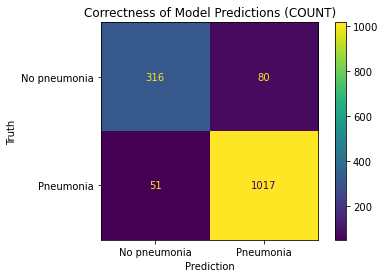

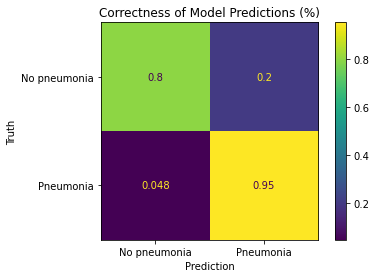

In [26]:
show_model_performance(model_fsm, x_test, y_test);

##### Top Model performance

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 8, 8, 8)           1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          6288      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 32)         

None

Accuracy: 93.03 %
Precision: 94.72 %
Recall: 95.78999999999999 %
F1 score: 95.25 %


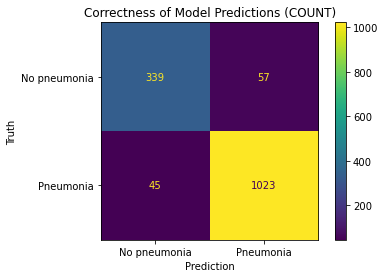

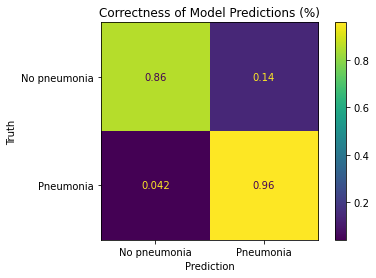

In [27]:
# CONFUSION MATRIX FOR TEST DATA, ***TOP MODEL***
path = IMG_PATH+'best_model_confusion_matrix'
show_model_performance(model_top, x_test, y_test, save_path=path);

## Step 5. Conclusion
Below is a comparison of the performance metrics for the baseline, first-simple and final models. 

#### Baseline performance:

In [28]:
preds = baseline_model(y_test)
truth = y_test[:, 1]
acc_pre_rec_f1(truth, preds)

Accuracy: 51.019999999999996 %
Precision: 73.61999999999999 %
Recall: 51.22 %
F1 score: 60.41 %


#### First simple model performance:

In [29]:
preds = np.argmax(model_fsm.predict(x_test), axis=-1)
truth = (y_test[:, 1]==1).astype('int')
acc_pre_rec_f1(truth, preds)

Accuracy: 91.05 %
Precision: 92.71000000000001 %
Recall: 95.22 %
F1 score: 93.95 %


#### Best model performance:

In [30]:
preds = np.argmax(model_top.predict(x_test), axis=-1)
truth = (y_test[:, 1]==1).astype('int')
acc_pre_rec_f1(truth, preds)

Accuracy: 93.03 %
Precision: 94.72 %
Recall: 95.78999999999999 %
F1 score: 95.25 %


As can be seen above, there is noteworthy improvement across the model development process. The best performing model does in fact enable results that are non-trivially better than the first simple model. However, it is also worth noting that for an application where speed was prioritized over performance, the first simple model is sufficiently viable. The training time was substantially lower, giving it merit of its own. 

### Future improvements
Although the above models are high performers, there is always room for improvement or further exploration. Some of those possibilities are discussed below.

- **Increase image resolution:** currently, photos are downsampled from roughly 800x1200 pixels to roughly 200x200 pixels. This choice was made to enable the script to run without crashing due to memory shortages. This issue is inherent to the methodology used to the images being stored in memory as a numpy array. However, analyzing these images in "batches" would eliminate the need to store an array in memory. As a result, more data could be analyzed. With more data, presumably the model could be more effective. 
- **Hyperparameter grid searches:** currently, ideal hyperparameters were selected based on some fine tuning and outside research. Note that not all iterations of those models are included in this notebook so that the notebook can run in a reasomnable amount of time. An exhaustive hyperparameter optimization is necessary to truly identify the top performing model, but that will be left for future analyses with more computational resources. 
- **Expandsion of scope:** Expansion to further x-ray image recognition datasets provided by the same academic researchers who provided this dataset (see README for citation). Testing these models on additional datasets could be an interesting project, and could provide insight regarding the broad applicability of the models at hand. 

### Citations
(1) Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.